In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

Loading the images

In [3]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("./images/picasso.jpg")
content_img = image_loader("./images/dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

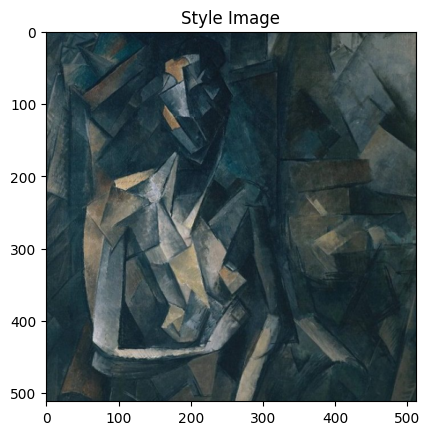

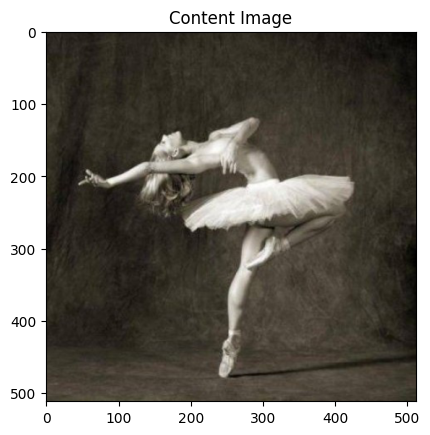

In [4]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [5]:
cnn = models.vgg19(weights=True).features.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 98.8MB/s]


In [6]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

from helper import Normalization, StyleLoss, ContentLoss

content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

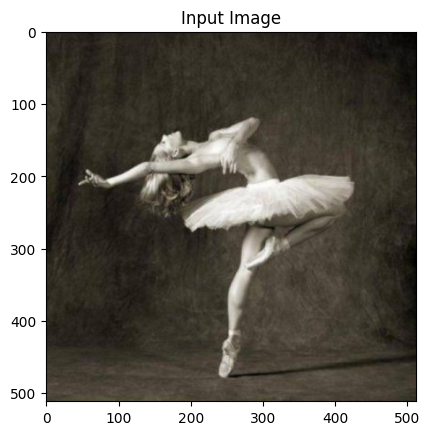

In [7]:
input_img = content_img.clone()
# if you want to use white noise by using the following code:
#
# ::
#
#    input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [8]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

def is_symmetric(matrix):
    # matrix = torch.tensor(matrix)
    if matrix.shape[0] != matrix.shape[1]:
        return False
    return torch.allclose(matrix, matrix.T)

def gram_matrix_to_vector(gram_matrix):
    n = gram_matrix.shape[0]
    indices = torch.triu_indices(n, n)
    return gram_matrix[indices[0], indices[1]]

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=1000,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)
    G_vector = None
    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            nonlocal G_vector
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            gram_matrix_values = 0
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            n = 1
            for sl in style_losses:
                style_score += sl.loss
                if run[0] == num_steps and n == len(style_losses):
                    gram_matrix_values = sl.gram
                    G_vector = gram_matrix_to_vector(gram_matrix_values)
                n += 1
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img, G_vector

Building the style transfer model..


/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Optimizing..
run [50]:
Style Loss : 4.125429 Content Loss: 4.222781

run [100]:
Style Loss : 1.115259 Content Loss: 3.025316

run [150]:
Style Loss : 0.711914 Content Loss: 2.656375

run [200]:
Style Loss : 0.476552 Content Loss: 2.502609

run [250]:
Style Loss : 0.343968 Content Loss: 2.409481

run [300]:
Style Loss : 0.262594 Content Loss: 2.357569

run [350]:
Style Loss : 0.210524 Content Loss: 2.322545

run [400]:
Style Loss : 0.180180 Content Loss: 2.296367

run [450]:
Style Loss : 0.164069 Content Loss: 2.276009

run [500]:
Style Loss : 0.154615 Content Loss: 2.260890

run [550]:
Style Loss : 0.149123 Content Loss: 2.249300

run [600]:
Style Loss : 0.145000 Content Loss: 2.240312

run [650]:
Style Loss : 0.142215 Content Loss: 2.232608

run [700]:
Style Loss : 0.140422 Content Loss: 2.226890

run [750]:
Style Loss : 0.138309 Content Loss: 2.222071

run [800]:
Style Loss : 0.137146 Content Loss: 2.218022

run [850]:
Style Loss : 0.135764 Content Loss: 2.214646

run [900]:
Style Lo

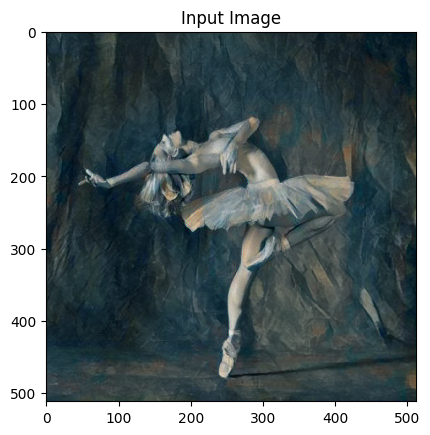

In [9]:
output, vect = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Input Image')
# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [20]:
print(vect.shape)

torch.Size([32896])
